# Romanization using LSTM net 
## Romanization is the process of converting one alphabet into another
### As example : 
## きゃ→ kya
## 글자→ geulja

# It is used for :
* helping learning new languages
* adapting boards and signs for travel places
* academic studies of phonetics
* modern keyboards for non latin languages

## As example of chinese keyboard :
<img src="https://cdn57.androidauthority.net/wp-content/uploads/2018/03/pinyin.gif" width="300px">

# How is done computationally ?

### context dependent grammar or context sensitive grammar :
* it is one of the most restricted grammars
* the rules depends upon all the characters of the string 
* the transformation reules will be different each time 

![M](https://i.stack.imgur.com/uEufx.png)

#### Example
![N](https://player.slideplayer.com/82/13559038/slides/slide_3.jpg)



# Road to the LSTM 
#### **Remember that DL is not only about the net but about the formating of the training data !!**
* <h3>Splitting</h3>
* <h3>Normalization</h3>
* <h3>Encoding</h3>


## 1. Splitting 

<h1>Let's use this input/output pair: 벽 → byeok</h1>

* Splitting jamo block

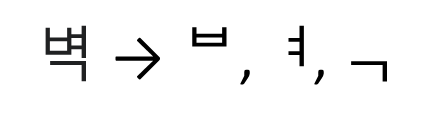

* Splitting the romanized version of the jamo block 
 
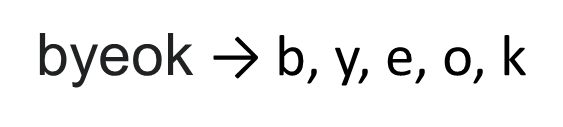

## 2. Normalization


* The normalization process it is used to ensure that the input and output length is the same 
* we , then, add the neutral component → **\x00** 

* The jamo 
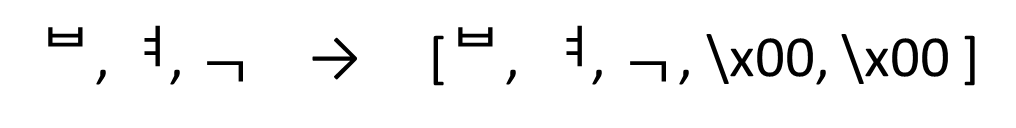
* The normalized 
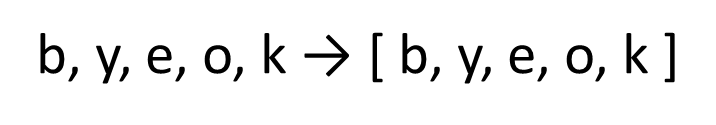

## 3. Encoding

* The vectorization transforms the string into some a vector of numbers , based on the position or a pre defined pair key-value
* ( those are random values )
* The jamo
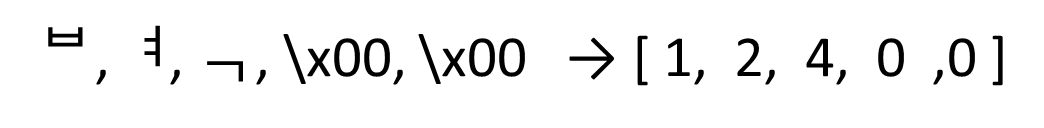
* The normalized 
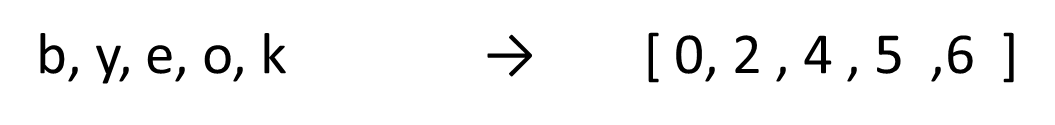

In [ ]:
import data 
from data import dataGen
from data.dataGen import main 
from IPython.display import display

if __name__ == "__main__":
    df = main()
    display(df)

# The LSTM 
### or long short term memory  
* more flexible
* can deal with large memory 
* can deal with large input sets 

# The system 
* the lstm deals with neurons that are individual nets 
* each of them process the input , generate an output 
* and pass the current state to the other neuron

## the architecture is as follows :

![a](https://www.researchgate.net/profile/Joshua-Peterson-7/publication/306257809/figure/fig1/AS:396269483773952@1471489415024/Simple-recurrent-neural-network.png)

***
the **input** is **x** 
<br>
the current **neuron state** is **h**  
the **output** is **y** 
***

#### the net works as the gif shows : 
![l](https://miro.medium.com/max/1920/1*n-IgHZM5baBUjq0T7RYDBw.gif)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import json
import jamotools
import os
import json
import datetime
import colorama
from colorama import Fore
import time
import difflib
from difflib import SequenceMatcher
import sys
from IPython.display import Markdown, display

global txtlog
txtlog = {
    "normalization":{
        "amount of normalized inputs":[],
        "amount of normalized outputs":[]
    },
    "Prediction Resume":{
        "with data input":[],
        "expected output":[],
        "the model predicted":[],
        "similarity":[]
    },
    "Header":{
        "input size":[],
        "tagset size":[],
        "hidden states dimension":[]
    },
    "Train basic info":{
        "learning rate":[],
        "total of iterations":[],
        "length of data base":[],
        "length of tag data base":[]
    },
    "Training live info":{
        "iteration":[],
        "actual input string":[],
        "actual expected tag":[],
        "error":[]
    },
    "Training Performance":{
        "started training at":[],
        "finished training at":[],
        "took":[]
    },
    "Prediction Performance":{
        "prediction started at":[],
        "prediction finished at":[],
        "took":[]
    },
}

# Print iterations progress
def printProgressBar (iteration, total, nn=" ",first_time = time.time() ,prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total:
        print("\nSucessfully trained...",nn)

class Tool():

    def __init__(self,path:str="my_train_data.json"):
        self.path = path
        return None

    def prepare_sequence(self,seq,to_ix):
        idxs = [to_ix[w] for w in seq]
        return torch.tensor(idxs, dtype=torch.long)

    def indexing(self,training_data):
        word_to_ix = {}
        for sent, tags in training_data:
            for word in sent:
                if word not in word_to_ix:
                    word_to_ix[word] = len(word_to_ix)
        return word_to_ix

    def file_name_def(self,file:str)->str:
        x = os.path.abspath('')
        y = x.split("\\")
        y.remove(y[len(y)-1])
        p = "\\".join(y)
        return p+r"\{z}".format(z=file)

    def decode(self,target,inpt):
        i = inpt
        vl = []
        vs = []
        for j in range(len(i)) :
            m = max(i[j])
            vl.append(j)
        vl = list(map(lambda x : -int(x) if x < 0 else int(x),vl))
        for t in target :
            if target[t] in vl:
                vs.append(t)
            else:
                pass
        return vs

    def open_read(self,hangul_data,hangul_to_ix,p):
        data_json = self.file_name_def(self.path)
        with open(data_json) as file:
            j = json.load(file)
        for k in j :
            ipt = k['input:']
            otp = k['output']
            e = (list(map(lambda x : x.encode('utf-8'),ipt)),list(otp))
            hangul_data.append(e)
        for y in hangul_data :
            for n in y[1]:
                if n in p:
                    pass
                else:
                    p.append(n)
        for f in p :
            hangul_to_ix[f] = p.index(f)
        hangul_to_ix[b'\x00'.decode('utf-8')] = 11
        for h in hangul_data:
            self.normalizer_check(h[0],h[1])
        
        return "created -> input set :{x} , output set -> {y}".format(x=hangul_data,y=hangul_to_ix)

    def normalizer_check(self,inpt,outp):
        normalized_times_i = 0
        normalized_times_o = 0

        condition0 = len(inpt) < len(outp)
        condition1 = len(outp) < len(inpt)
        if condition0 :
            while condition0 :
                inpt.append(b'\x00')
                condition0 = len(inpt) < len(outp)
                normalized_times_i+=1

        if condition1 :
            while condition1 :
                outp.append(b'\x00'.decode('utf-8'))
                condition1 = len(outp) < len(inpt)
                normalized_times_o+=1

        txtlog['normalization']['amount of normalized inputs'].append(str(normalized_times_i))
        txtlog['normalization']['amount of normalized outputs'].append(normalized_times_o)


    def myLogger(self,hd,htx,prdct):
        decode_prdct = "".join(self.decode(hangul_to_ix,prdct[0])) # decodificamos a saida
        decode_utf = list(map(lambda x : x.decode('utf-8'),prdct[0]))
        decode_inpt = jamotools.join_jamos(decode_utf)
        h = "".join(prdct[1])
        ph = round(SequenceMatcher(None,h,decode_prdct).ratio()*100)
        if ph > 50 :
            ph = Fore.GREEN+str(ph)+"%"+Fore.RESET
        else:
            ph = Fore.RED+str(ph)+"%"+Fore.RESET

        log = """
-----
    -- Prediction Resume --
with data input -> {i} ;
expected output -> {h} ;
and the model predicted -> {d} ;
similarity -> {w}
    -- end --

-----
""".format(i=Fore.GREEN+decode_inpt+Fore.RESET,h=Fore.GREEN+h+Fore.RESET,d=Fore.RED+decode_prdct+Fore.RESET,w=ph)
        print(log)
        txtlog["Prediction Resume"]["with data input"].append(decode_inpt)
        txtlog["Prediction Resume"]["expected output"].append(h)
        txtlog["Prediction Resume"]["the model predicted"].append(decode_prdct)
        txtlog["Prediction Resume"]["similarity"].append(ph)



class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, train_data, tagset):
        super(LSTMTagger, self).__init__()
        self.t = Tool()
        self.vocab_size = len(self.t.indexing(train_data))
        self.tagset_size = len(tagset)
        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(self.vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        txtlog["Header"]["input size"].append(self.vocab_size)
        txtlog["Header"]["tagset size"].append(self.tagset_size)
        txtlog["Header"]["hidden states dimension"].append(self.hidden_dim)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

    def train(self,base_data,base_tag,iteration,learning):
        t = Tool()
        data = self.t.indexing(base_data)
        self.data = data
        loss_function = nn.NLLLoss()
        optimizer = optim.SGD(self.parameters(), lr=learning)

        txtlog["Train basic info"]["learning rate"].append(learning)
        txtlog["Train basic info"]["total of iterations"].append(iteration)
        txtlog["Train basic info"]["length of data base"].append(len(base_data))
        txtlog["Train basic info"]["length of tag data base"].append(len(base_tag))


        with torch.no_grad():
            inputs = self.t.prepare_sequence(base_data[0][0], data)
            tag_scores = model(inputs)
        dx = datetime.datetime.now()
        start = time.time()
        for epoch in range(iteration):
            for sentence, tags in base_data:
                model.zero_grad()
                sentence_in = self.t.prepare_sequence(sentence, data)
                targets = self.t.prepare_sequence(tags, base_tag)
                tag_scores = model(sentence_in)
                loss = loss_function(tag_scores, targets)

                s=list(map(lambda x : x.decode('utf-8') if x != b"\x00" else " ",sentence))
                txtlog["Training live info"]["iteration"].append(epoch)
                txtlog["Training live info"]["actual input string"].append(s)
                txtlog["Training live info"]["actual expected tag"].append("".join(tags))
                txtlog["Training live info"]["error"].append(loss.tolist())

                loss.backward()
                optimizer.step()
            end = time.time()
            dy = datetime.datetime.now()

            txtlog["Training Performance"]["started training at"].append(str(dx))
            txtlog["Training Performance"]["finished training at"].append(str(dy))
            txtlog["Training Performance"]["took"].append(str(end-start))

            if epoch == iteration-1:printProgressBar(epoch,iteration-1,fill=Fore.GREEN+'█'+Fore.RESET,nn=Fore.GREEN+" took "+str(round(end - start,2))+" seconds"+Fore.RESET)
            elif epoch <= int(iteration/2):printProgressBar(epoch,iteration-1,fill=Fore.RED+'█'+Fore.RESET)
            else:printProgressBar(epoch,iteration-1,fill=Fore.YELLOW+'█'+Fore.RESET)

        return None

    def predict(self,predict_data,data_aux=" "):
        print('.\n.\n.\nStarted prediction...')
        d0 = str(datetime.datetime.now())
        start = time.time()
        with torch.no_grad():
            if data_aux != " ":
                inputs = self.t.prepare_sequence(predict_data, self.t.indexing(data_aux))
            else:
                inputs = self.t.prepare_sequence(predict_data, self.data)
            tag_scores = self.forward(inputs)
        end = time.time()
        d1 = str(datetime.datetime.now())
        tk= end-start

        txtlog["Prediction Performance"]["prediction started at"].append(d0)
        txtlog["Prediction Performance"]["prediction finished at"].append(d1)
        txtlog["Prediction Performance"]["took"].append(tk)

        print("Ended prediction in..."+Fore.GREEN+" took "+str(round(tk,4))," seconds"+Fore.RESET)
        return tag_scores

    def customLogger(self,func):
        def logger(*args,**kwargs):
            func(*args,**kwargs)
            return True
        return logger

if __name__ == "__main__":
    
    def printmd(string):
        display(Markdown(string))
    
    printmd("## Hangul position: ")
    
    n_hangul = input("|> ")
    
    printmd("## Rounds: ")
    round_inpt = input("|> ")
    
    printmd("## Gen or Byload: ")
    mode = input("|> ")
    
    hangul_data = [] 
    hangul_to_ix = {} 
    p = [] 

    t = Tool("\\torch_\\data\\train_data.json") 
    t.open_read(hangul_data,hangul_to_ix,p) 
    
    selected_hangul = []
    argv_hangul_encoded = hangul_data[int(n_hangul)]
    model = LSTMTagger(7, 7, hangul_data, hangul_to_ix) 
    try:
        if mode == "byload":
            try:
                print(Fore.GREEN+"Loaded model"+Fore.RESET)
                model.load_state_dict(torch.load(t.file_name_def('\\torch_\model_dir\\model.pth')))
                prdct = model.predict(argv_hangul_encoded[0],hangul_data)
            except Exception as e:
                print(e)
                print(Fore.RED+"Failed in attempt to load the model"+Fore.RESET)
                sys.exit()
                pass
        elif mode == "gen":
            model.train(hangul_data,hangul_to_ix,int(round_inpt),0.1) 
            prdct = model.predict(argv_hangul_encoded[0]) 
    except IndexError:
        model.train(hangul_data,hangul_to_ix,int(round_inpt),0.1) 
        prdct = model.predict(argv_hangul_encoded[0])


    @model.customLogger 
    def log():t.myLogger(hangul_data,hangul_to_ix,argv_hangul_encoded)
    log() 


    sig = datetime.datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
    with open(t.file_name_def('\\torch_\\logs\\log{n}.json'.format(n=sig)),'w',encoding='utf-8') as JsonFile:
        json.dump(txtlog,JsonFile)
    try:
        torch.save(model.state_dict(),t.file_name_def('\\torch_\\model_dir\\model.pth'))
        print(Fore.GREEN+"Saved model in model_dir..."+Fore.RESET)
    except:
        print(Fore.RED+"Saving failed..."+Fore.RESET)


In [ ]:
import matplotlib.pyplot as plt
import json 

t = Tool()
url = t.file_name_def("\\torch_\\logs\\exports\\log03_17_2021_10_21_22.json")
with open(url) as JsonFile:
    j = json.load(JsonFile)

info = j["Pure Data"]

plt.plot(info,[i for i in range(len(info))])
plt.ylabel("error")
plt.show()


# Powered by :

![i1](https://miro.medium.com/max/2400/1*aqNgmfyBIStLrf9k7d9cng.jpeg)
![i0](https://pplware.sapo.pt/wp-content/uploads/2015/12/perl6.jpg)

# References :
##### korean romanization
* *Noma, Hideki (2005). "Korean". In Strazny, Philipp (ed.). Encyclopedia of Linguistics. 1. Taylor & Francis. pp. 579–584. ISBN 978-1-57958-450-4.*
##### piyin keyboard
* *CHEN, Zheng; LEE, Kai-Fu. A new statistical approach to Chinese Pinyin input. In: Proceedings of the 38th Annual Meeting of the Association for Computational Linguistics. 2000. p. 241-247.*
##### lstm introduction
* *SUNDERMEYER, Martin; SCHLÜTER, Ralf; NEY, Hermann. LSTM neural networks for language modeling. In: Thirteenth annual conference of the international speech communication association. 2012.*